#Google drive annexation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Libraries

In [ ]:
import librosa
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os

#Load audio and labels

In [ ]:
#Load the audio file
# audio_path = "/content/drive/MyDrive/thesis/clips_lakers.wav"
audio_path = os.path.join(os.path.dirname(__file__), 'clips_lakers.wav')
audio, sr = librosa.load(audio_path, sr=None)

In [ ]:
#Load labels from the CSV file
labels_path = os.path.join(os.path.dirname(__file__), 'test_cheering.csv')
labels_df = pd.read_csv(labels_path)
labels_df = labels_df.drop(['VALUE'], axis=1)

#hold rows corresponding to cheering events

cheering_labels_df = labels_df.loc[labels_df['LABEL'] == 'cheering']


#MFCC computation and labelling

In [ ]:
#Compute the MFCCs of the audio
n_fft = 2048
hop_length = 512

mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

In [ ]:
# Label MFCCs based on the corresponding CSV labels


positive_labeled_mfccs_list = []
mfccs_labels = np.zeros(mfccs.shape[1])

for i, row in cheering_labels_df.iterrows():
    start_time = row["TIME"]
    end_time = start_time + row["DURATION"]
    label = row["LABEL"]

    # Convert the start and end times from seconds to samples
    start_sample = int(start_time * sr/hop_length)
    end_sample = int(end_time * sr/hop_length)

    
     # Extract the MFCCs for the labeled segment of the audio
    positive_labeled_mfccs = mfccs[:, start_sample:end_sample]
    mfccs_labels[start_sample:end_sample] = 1
    
    # Append the labeled MFCCs to the list
    positive_labeled_mfccs_list.append(positive_labeled_mfccs)

   
# Concatenate the list of labeled MFCCs into a single array
positive_labeled_mfccs = np.concatenate(positive_labeled_mfccs_list, axis=1)

#SVM training

In [ ]:
mfccs_trans = mfccs.T

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfccs_trans, mfccs_labels, test_size=0.2)

# Downsample the "0" labeled MFCCs
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_0_downsampled = resample(X_train_0, replace=False, n_samples=X_train_1.shape[0], random_state=123)
X_train_downsampled = np.vstack((X_train_0_downsampled, X_train_1))
y_train_downsampled = np.hstack((np.zeros(X_train_0_downsampled.shape[0]), np.ones(X_train_1.shape[0])))


X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1]
X_test_0_downsampled = resample(X_test_0, replace=False, n_samples=X_test_1.shape[0], random_state=123)
X_test_downsampled = np.vstack((X_test_0_downsampled, X_test_1))
y_test_downsampled = np.hstack((np.zeros(X_test_0_downsampled.shape[0]), np.ones(X_test_1.shape[0])))

In [ ]:
# Train the SVM on the balanced dataset
svm = SVC(kernel='rbf')
svm.fit(X_train_downsampled, y_train_downsampled)

SVC()

#Predictions

##Downsampled test set

Accuracy : 0.898011704152859, Precision: 0.8726564562978611, Recall : 0.9320313050835507


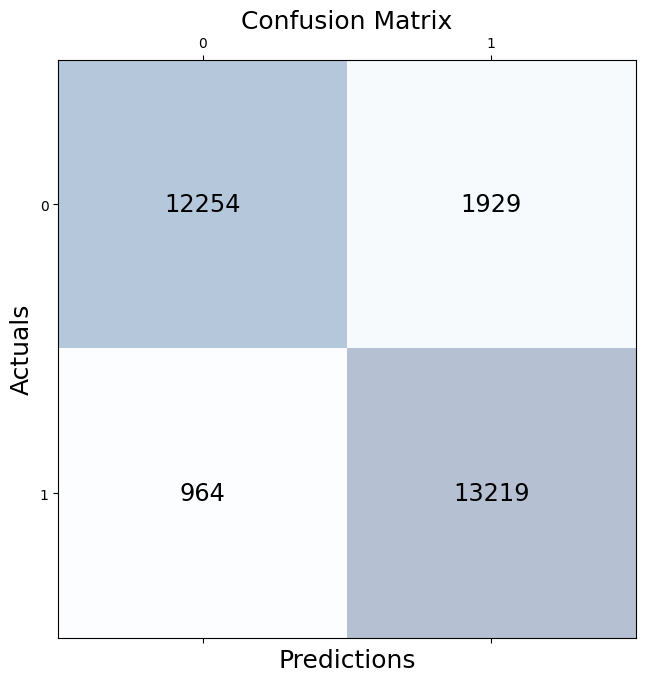

In [ ]:
#test on downsampled test set
y_pred = svm.predict(X_test_downsampled)

tn, fp, fn, tp = confusion_matrix(y_test_downsampled, y_pred).ravel()

precision_score = tp/(tp+fp)
recall_score = tp/(tp+fn)
accuracy = accuracy_score(y_test_downsampled, y_pred)

print(f"Accuracy : {accuracy}, Precision: {precision_score}, Recall : {recall_score}")

conf_matrix = confusion_matrix(y_test_downsampled, y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

##Whole test set

Accuracy : 0.873943861379808, Precision: 0.33166900843034924, Recall : 0.9320313050835507


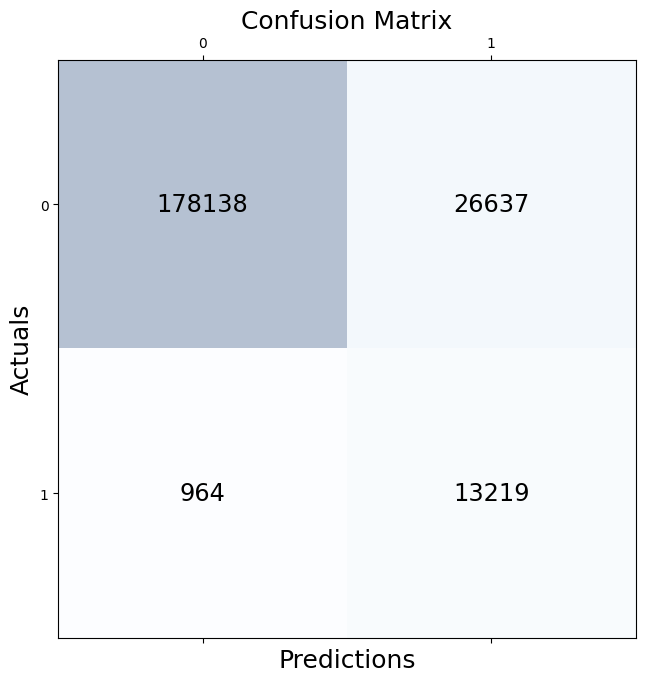

In [ ]:
predicted_y = svm.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, predicted_y).ravel()

precision_score = tp/(tp+fp)
recall_score = tp/(tp+fn)
accuracy = accuracy_score(y_test, predicted_y)

print(f"Accuracy : {accuracy}, Precision: {precision_score}, Recall : {recall_score}")

conf_matrix = confusion_matrix(y_test, predicted_y)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

##GridSearch for optimal hyperparameters of SVM

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the SVM model with an RBF kernel
svm = SVC(kernel='rbf')

# Set up the parameter grid for hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1],
              'gamma': [0.1, 1, 10]}
            #   'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 50}]}

# Use grid search to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Train the SVM with the best hyperparameters
svm_best = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
svm_best.fit(X_train, y_train)

# Test the SVM
y_pred = svm_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#Train SVM_2 using mfcc&derivatives

##delta and delta_2 computation and labelling

In [ ]:
# Compute first and second derivatives of MFCCs coefficients
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

# Concatenate MFCCs and its derivatives into a feature vector
features = np.hstack((mfccs, delta_mfccs, delta2_mfccs))

# Label delta, delta_2 based on the corresponding CSV labels


delta_mfccs_labels = np.zeros(delta_mfccs.shape[1])
delta2_mfccs_labels = np.zeros(delta2_mfccs.shape[1])

for i, row in cheering_labels_df.iterrows():
    start_time = row["TIME"]
    end_time = start_time + row["DURATION"]
    label = row["LABEL"]

    # Convert the start and end times from seconds to samples
    start_sample = int(start_time * sr/hop_length)
    end_sample = int(end_time * sr/hop_length)

    
     # Extract the delta, delta_2 mfccs for the labeled segment of the audio
    delta_mfccs_labels[start_sample:end_sample] = 1
    delta2_mfccs_labels[start_sample:end_sample] = 1

features_labels = np.concatenate((mfccs_labels, delta_mfccs_labels, delta2_mfccs_labels), axis=0)

features_labels.shape




(1642182,)

##Train-test split and training

In [ ]:


features_trans = features.T #Invert dimensions for SVM

# Split the data into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_trans, features_labels, test_size=0.2)

# Downsample the "0" labeled MFCCs
X_train_0_2 = X_train_2[y_train_2 == 0]
X_train_1_2 = X_train_2[y_train_2 == 1]
X_train_0_downsampled_2 = resample(X_train_0_2, replace=False, n_samples=X_train_1_2.shape[0], random_state=123)
X_train_downsampled_2 = np.vstack((X_train_0_downsampled_2, X_train_1_2))
y_train_downsampled_2 = np.hstack((np.zeros(X_train_0_downsampled_2.shape[0]), np.ones(X_train_1_2.shape[0])))


X_test_0_2 = X_test_2[y_test_2 == 0]
X_test_1_2 = X_test_2[y_test_2 == 1]
X_test_0_downsampled_2 = resample(X_test_0_2, replace=False, n_samples=X_test_1_2.shape[0], random_state=123)
X_test_downsampled_2 = np.vstack((X_test_0_downsampled_2, X_test_1_2))
y_test_downsampled_2 = np.hstack((np.zeros(X_test_0_downsampled_2.shape[0]), np.ones(X_test_1_2.shape[0])))

In [ ]:
# Train the SVM on the balanced dataset
svm = SVC(kernel='rbf')
svm.fit(X_train_downsampled, y_train_downsampled)

SVC()

##Predictions

###Downsampled Test set

0.8798025613660619 0.3101048572906381


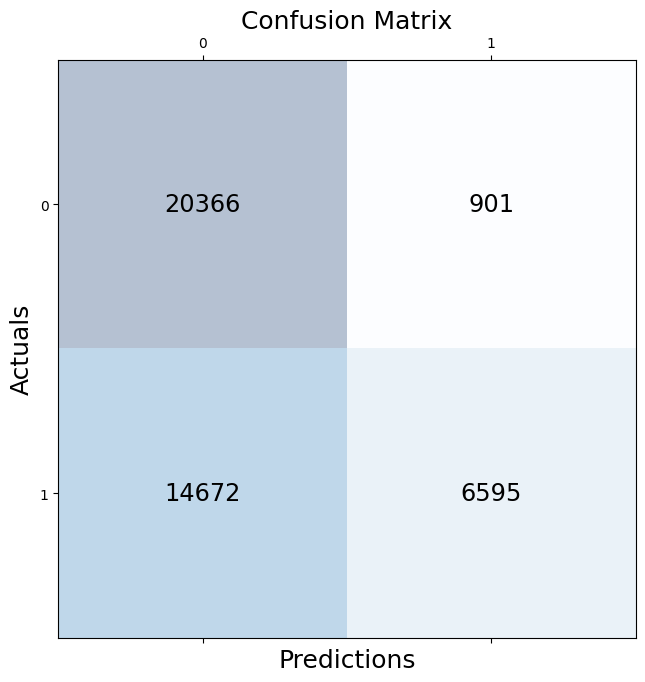

In [ ]:
#test on downsampled test set
y_pred_2 = svm.predict(X_test_downsampled_2)

tn_2, fp_2, fn_2, tp_2 = confusion_matrix(y_test_downsampled_2, y_pred_2).ravel()

precision_score_2 = tp_2/(tp_2+fp_2)
recall_score_2 = tp_2/(tp_2+fn_2)

print(precision_score_2, recall_score_2)

conf_matrix_2= confusion_matrix(y_test_downsampled_2, y_pred_2)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix_2, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_2.shape[0]):
    for j in range(conf_matrix_2.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_2[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Cheering :

 **-MFCCs** : 
  
 1. *Downsampled_test_set : accuracy = 0.9, precision = 0.87, recall = 0.93* 
         
 2. *Whole test set : accuracy = 0.88, precision = 0.33,   recall = 0.93*


+ Καλό : υψηλό recall - αναγνωρίζει τους ήχους που είναι labelled ως cheering

+ Κακό: χαμηλό precision-αναγνωρίζει και άλλους ήχους ως cheering(αίτια : boos,θόρυβος)

**MFCCs,derivatives** : 

 1. *Downsampled_test_set : precision = 0.88, recall = 0.31* 